In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

/home/flandes/local_installs/mambaforge/envs/e3nn/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/flandes/local_installs/mambaforge/envs/e3nn/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
Dinput = 10
Doutput = 10
N = 1000000
X = np.random.random((N,Dinput))
X = torch.tensor(X, dtype=torch.float32).detach()
Y = X


Xt = np.random.random((N,Dinput))
Xt = torch.tensor(X, dtype=torch.float32).detach()
Yt = Xt


/tmp/ipykernel_967676/3127261550.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xt = torch.tensor(X, dtype=torch.float32).detach()


In [5]:
class Simple1layerMLP(nn.Module):
    
    def __init__(self, layers):
        super(Simple1layerMLP, self).__init__()
        self.l1 = nn.Linear(layers[0], layers[1])
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        return x


In [6]:
layers=[Dinput, Doutput]
myMLP1 = Simple1layerMLP(layers) ## only 1 layer !!


## TODO:
- write a train function. It should return a list or array of the loss recorded over epochs.
- train the network, plot the loss over epochs (here the train loss could be enough, you can also plot the valid. loss)
- help the network by initializing the weights in a smart way (since you know what you want to learn..)
- compare the 2 training curves (with and without the expert initialization of weights)
- other things to try:
     + change the L2 regularization parameter (weight_decay)
     + try also with a larger MLP, e.g. with layers (10, 20, 20, 10)
     + Other things: change e.g. the batch size

## Train function

In [7]:
import time

In [8]:
def train(num_epochs, batch_size, criterion, optimizer, model, trainset):
    # we re-define `trainloader` so as to be able to choose the batch size:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    t0 =time.time()
    
    model.train() ## tells pytorch we are in train mode, not in test mode.
    running_losses=[]
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            X, Y = data

            # zero the parameter's gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize :            
            ## forward pass
            y = model(X)  # because torch tensors keep parameters values AND the computational graph,
                                     # the torch object 'output' will be able to store also the gradients
            # note: outputs has a shape:  batch_size x #labels  = 4 x 10  (+gradients)

            ## backward pass
            loss = criterion(y, Y)  ## loss is also a torch object, so it also has the comput. graph.
            loss.backward() # computes and stores the gradients next to the tensors of parameters themselves.
            # at this point, the object 'model' has the gradients in it at the correct value.

            ## update of gradients
            optimizer.step() # updates the parameters wrt the local gradient
            ## recall that we defined:  optimizer = optim.SGD(model.parameters(), ... so it knows about the parameters.

            
            # print statistics
            running_loss += loss.item()
        print(f'[{epoch + 1}] loss: {running_loss}')
        running_losses.append(running_loss)
        running_loss = 0.0
        
    t1 =time.time()
    print('Finished Training. It took '+str(t1-t0)+" seconds")
    return running_losses


## Normal training

In [9]:
import time
t1=time.time()
t2=time.time()

In [12]:
t1=time.time()
layers=[Dinput, Doutput]
myMLP1 = Simple1layerMLP(layers) ## only 1 layer !!

learning_rate=1
num_epochs=100
batch_size=10000
criterion = nn.MSELoss()
model = myMLP1
weight_decay=1e-8
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainset = (X, Y)
running_losses = train(num_epochs, batch_size, criterion, optimizer, model, trainset)

running_losses_normal_init = np.array(running_losses).copy()


t2=time.time()
t2-t1

[1] loss: 0.2291233241558075
[2] loss: 0.17802321910858154
[3] loss: 0.14300087094306946
[4] loss: 0.11684499680995941
[5] loss: 0.10220327228307724
[6] loss: 0.09332225471735
[7] loss: 0.08923596143722534
[8] loss: 0.08624906092882156
[9] loss: 0.08345305919647217
[10] loss: 0.08075327426195145
[11] loss: 0.07813938707113266
[12] loss: 0.07560859620571136
[13] loss: 0.0731586441397667
[14] loss: 0.07078718394041061
[15] loss: 0.06849204003810883
[16] loss: 0.06627090275287628
[17] loss: 0.06412164866924286
[18] loss: 0.062042236328125
[19] loss: 0.06003044918179512
[20] loss: 0.05808417499065399
[21] loss: 0.05620136111974716
[22] loss: 0.05438007414340973
[23] loss: 0.05261833593249321
[24] loss: 0.0509142205119133
[25] loss: 0.04926590621471405
[26] loss: 0.04767158627510071
[27] loss: 0.0461294986307621
[28] loss: 0.04463793337345123
[29] loss: 0.043195270001888275
[30] loss: 0.04179989919066429
[31] loss: 0.04045027866959572
[32] loss: 0.03914489969611168
[33] loss: 0.037882324308

36.64782214164734

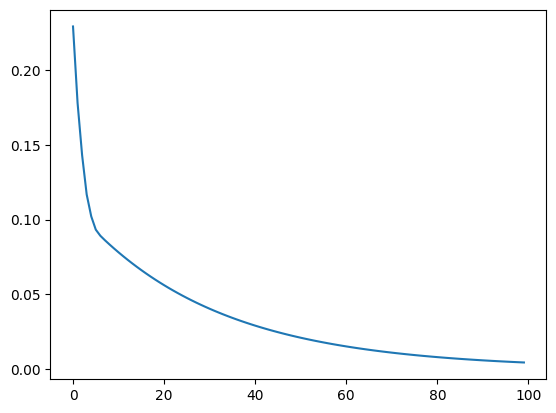

In [14]:
plt.plot(running_losses_normal_init)

In [16]:
t2-t1

36.64782214164734

In [20]:
myMLP1.state_dict().keys(), 

odict_keys(['l1.weight', 'l1.bias'])

In [21]:
myMLP1.state_dict()['l1.bias']

tensor([ 0.1758,  0.1304,  0.2162,  0.2333,  0.0327, -0.0068,  0.2225,  0.0787,
        -0.0806,  0.0186])

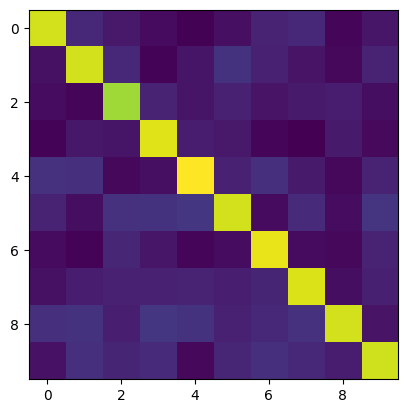

In [17]:
plt.imshow(myMLP1.state_dict()['l1.weight'])

In [18]:
torch.mean((myMLP1.forward(X)-X)**2)

tensor(0.0044, grad_fn=<MeanBackward0>)

## Training with a hint (we add the Identity matrix to the initial weights)

In [13]:
## re-set network
layers=[Dinput, Doutput]
myMLP1_boosted = Simple1layerMLP(layers) ## only 1 layer !!
running_losses_normal_init
## we give a boost:
myMLP1_boosted.l1.weight.data += torch.eye(Dinput)

In [14]:
learning_rate=1
num_epochs=100
batch_size=10000
criterion = nn.MSELoss()
model = myMLP1_boosted
weight_decay=1e-8
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainset = X, Y
running_losses = train(num_epochs, batch_size, criterion, optimizer, model, trainset)

running_losses_boosted = np.array(running_losses).copy()

[1] loss: 0.0781811997294426
[2] loss: 0.026514394208788872
[3] loss: 0.020166324451565742
[4] loss: 0.018808240070939064
[5] loss: 0.018193747848272324
[6] loss: 0.017709529027342796
[7] loss: 0.017255932092666626
[8] loss: 0.016816183924674988
[9] loss: 0.016387365758419037
[10] loss: 0.015968777239322662
[11] loss: 0.015560156665742397
[12] loss: 0.015161233954131603
[13] loss: 0.014771834015846252
[14] loss: 0.014391756616532803
[15] loss: 0.014020828530192375
[16] loss: 0.013658834621310234
[17] loss: 0.013305583968758583
[18] loss: 0.012960889376699924
[19] loss: 0.012624588795006275
[20] loss: 0.01229651365429163
[21] loss: 0.011976459063589573
[22] loss: 0.011664237827062607
[23] loss: 0.011359678581357002
[24] loss: 0.011062633246183395
[25] loss: 0.010772923938930035
[26] loss: 0.01049035880714655
[27] loss: 0.01021476462483406
[28] loss: 0.009946005418896675
[29] loss: 0.00968394335359335
[30] loss: 0.009428421035408974
[31] loss: 0.00917929969727993
[32] loss: 0.00893645454

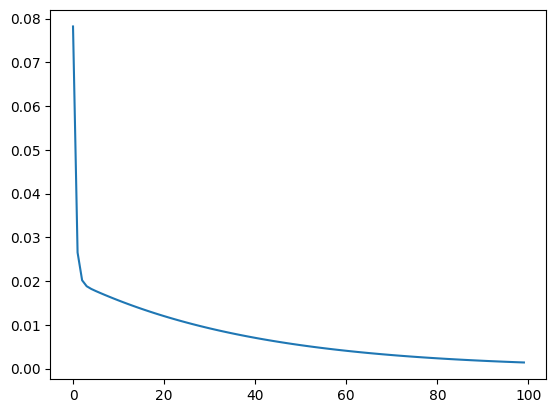

In [15]:
plt.plot(running_losses_boosted)

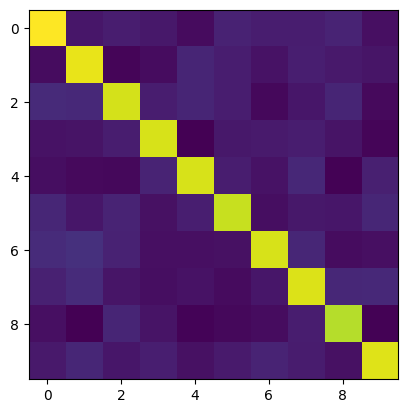

In [16]:
plt.imshow(myMLP1_boosted.state_dict()['l1.weight'])

In [17]:
torch.mean((myMLP1_boosted.forward(X)-X)**2)

tensor(0.0013, grad_fn=<MeanBackward0>)

In [18]:
myMLP1_boosted.state_dict()['l1.bias']

tensor([-0.0323,  0.0568, -0.0373,  0.1091,  0.0715,  0.0025, -0.0123, -0.0256,
         0.2099, -0.0148])

## Comparing normal approach and the one with smart initialization

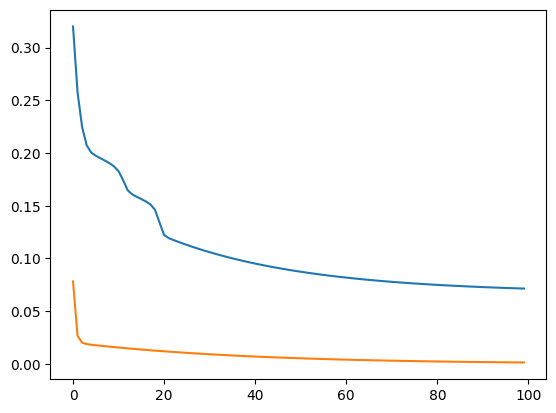

In [19]:
plt.plot(running_losses_normal_init)
plt.plot(running_losses_boosted)

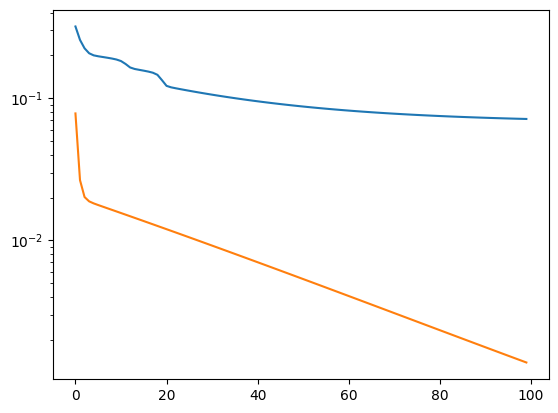

In [20]:
plt.semilogy(running_losses_normal_init)
plt.semilogy(running_losses_boosted)

# With a deeper MLP 
## With a 3-layer MLP: harder or easier ?

In [21]:
class Simple3layerMLP(nn.Module):
    
    def __init__(self, layers):
        super(Simple3layerMLP, self).__init__()
        
        self.l1 = nn.Linear(layers[0], layers[1])
        self.l2 = nn.Linear(layers[1], layers[2])
        self.l3 = nn.Linear(layers[2], layers[3])

    def forward(self, x):       
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        return x


In [22]:
# Create the model:
layers=[Dinput, Dinput*2, Doutput*2, Doutput]
myMLP3 = Simple3layerMLP(layers)


In [23]:
learning_rate=1
num_epochs=100
batch_size=10000
criterion = nn.MSELoss()
model = myMLP3
weight_decay=1e-8
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainset = X, Y
running_losses = train(num_epochs, batch_size, criterion, optimizer, model, trainset)

running_losses_3layers = running_losses.copy()

[1] loss: 0.2856883108615875
[2] loss: 0.24939170479774475
[3] loss: 0.21984495222568512
[4] loss: 0.20181067287921906
[5] loss: 0.19157028198242188
[6] loss: 0.18617285788059235
[7] loss: 0.18352539837360382
[8] loss: 0.18226924538612366
[9] loss: 0.1816430240869522
[10] loss: 0.18127822875976562
[11] loss: 0.18101604282855988
[12] loss: 0.18079330027103424
[13] loss: 0.18058565258979797
[14] loss: 0.18038399517536163
[15] loss: 0.1801847368478775
[16] loss: 0.179986372590065
[17] loss: 0.1797882318496704
[18] loss: 0.17958971858024597
[19] loss: 0.17939022183418274
[20] loss: 0.179188534617424
[21] loss: 0.17898139357566833
[22] loss: 0.17875723540782928
[23] loss: 0.17844915390014648
[24] loss: 0.17722177505493164
[25] loss: 0.1668621003627777
[26] loss: 0.1479852944612503
[27] loss: 0.13222262263298035
[28] loss: 0.12800830602645874
[29] loss: 0.12688428163528442
[30] loss: 0.12641090154647827
[31] loss: 0.1260792315006256
[32] loss: 0.12577877938747406
[33] loss: 0.125482618808746

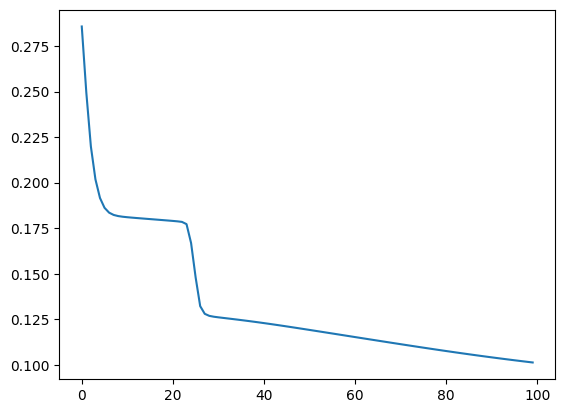

In [24]:
plt.plot(running_losses)

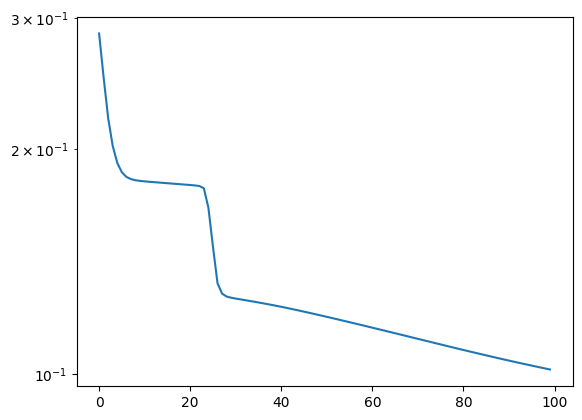

In [25]:
plt.semilogy(running_losses)

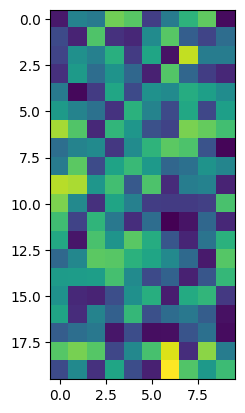

In [26]:
plt.imshow(myMLP3.state_dict()['l1.weight'])

In [27]:
torch.mean((myMLP3.forward(X)-X)**2)

tensor(0.1010, grad_fn=<MeanBackward0>)

## Wider MLP

In [9]:
class Simple2layerMLP(nn.Module):
    
    def __init__(self, layers):
        super(Simple2layerMLP, self).__init__()
        
        self.l1 = nn.Linear(layers[0], layers[1])
        self.l2 = nn.Linear(layers[1], layers[2])

    def forward(self, x):       
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        return x


In [11]:
# Create the model:
layers=[Dinput,100, Doutput]
myMLP2 = Simple2layerMLP(layers)


In [12]:
learning_rate=1
num_epochs=30
batch_size=10
criterion = nn.MSELoss()
model = myMLP2
weight_decay=1e-8
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainset = X, Y
running_losses = train(num_epochs, batch_size, criterion, optimizer, model, trainset)

running_losses_2layers = running_losses.copy()

[1] loss: 0.23601065576076508
[2] loss: 1.1090604066848755
[3] loss: 0.3248067796230316
[4] loss: 0.3207184374332428
[5] loss: 0.3141295313835144
[6] loss: 0.308967649936676
[7] loss: 0.28824225068092346
[8] loss: 0.28423646092414856
[9] loss: 0.281186580657959
[10] loss: 0.2789285480976105
[11] loss: 0.27718016505241394
[12] loss: 0.2758028507232666
[13] loss: 0.274676650762558
[14] loss: 0.2737378776073456
[15] loss: 0.272938996553421
[16] loss: 0.27225127816200256
[17] loss: 0.27165350317955017
[18] loss: 0.2711307406425476
[19] loss: 0.2706716060638428
[20] loss: 0.2702670097351074
[21] loss: 0.26990965008735657
[22] loss: 0.26959338784217834
[23] loss: 0.2693132162094116
[24] loss: 0.2690645456314087
[25] loss: 0.26884371042251587
[26] loss: 0.2686472237110138
[27] loss: 0.2684723138809204
[28] loss: 0.2683163583278656
[29] loss: 0.26817721128463745
[30] loss: 0.2680528461933136
Finished Training. It took 116.11963772773743 seconds


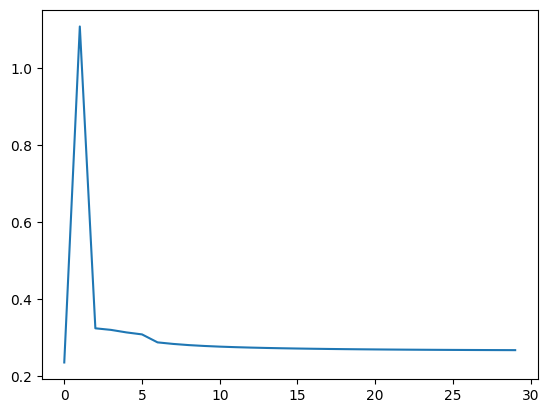

In [13]:
plt.plot(running_losses_2layers)

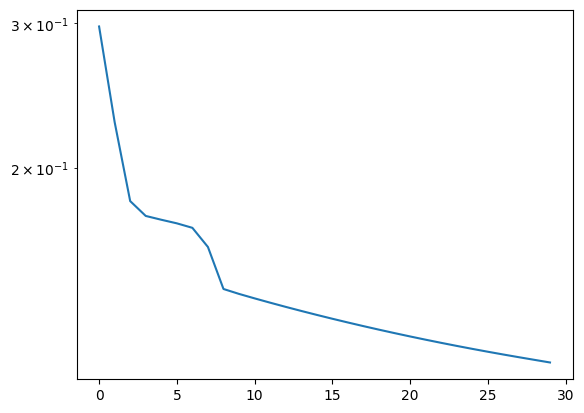

In [32]:
plt.semilogy(running_losses_2layers)

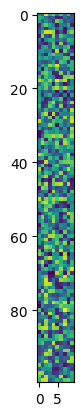

In [33]:
plt.imshow(myMLP2.state_dict()['l1.weight'])

In [34]:
torch.mean((myMLP2.forward(X)-X)**2)

tensor(0.1147, grad_fn=<MeanBackward0>)

## back to single-layer MLP but with smaller batch size

In [35]:
# Create the model:
layers=[Dinput, Doutput]
myMLP1 = Simple1layerMLP(layers)


In [36]:
learning_rate=1
num_epochs=100
batch_size=3
criterion = nn.MSELoss()
model = myMLP1
weight_decay=1e-8
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainset = X, Y
running_losses = train(num_epochs, batch_size, criterion, optimizer, model, trainset)

running_losses_smaller_batch = np.array(running_losses).copy()

[1] loss: 0.24779190123081207
[2] loss: 0.23206104338169098
[3] loss: 0.22080710530281067
[4] loss: 0.20994974672794342
[5] loss: 0.19936424493789673
[6] loss: 0.1834460198879242
[7] loss: 0.16616934537887573
[8] loss: 0.15621566772460938
[9] loss: 0.1464768946170807
[10] loss: 0.13123545050621033
[11] loss: 0.11484819650650024
[12] loss: 0.10800539702177048
[13] loss: 0.10512345284223557
[14] loss: 0.10275288671255112
[15] loss: 0.10049602389335632
[16] loss: 0.09831409901380539
[17] loss: 0.09620214998722076
[18] loss: 0.0941581204533577
[19] loss: 0.09218018501996994
[20] loss: 0.09026656299829483
[21] loss: 0.08841529488563538
[22] loss: 0.08662446588277817
[23] loss: 0.08489222079515457
[24] loss: 0.08321668952703476
[25] loss: 0.08159606158733368
[26] loss: 0.08002860844135284
[27] loss: 0.07851260155439377
[28] loss: 0.07704634964466095
[29] loss: 0.07562827318906784
[30] loss: 0.0742567628622055
[31] loss: 0.07293029874563217
[32] loss: 0.07164738327264786
[33] loss: 0.07040660

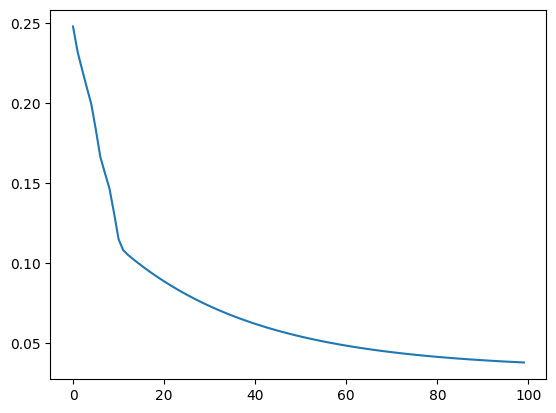

In [37]:
plt.plot(running_losses_smaller_batch)

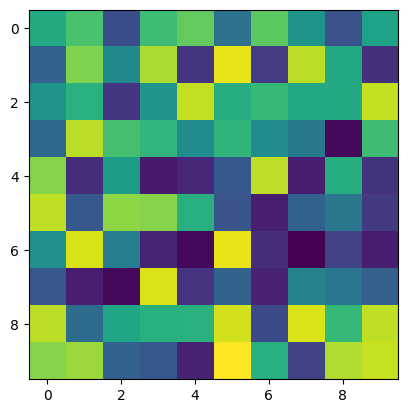

In [38]:
layers=[Dinput, Doutput]
myMLP1 = Simple1layerMLP(layers) ## only 1 layer !!
plt.imshow(myMLP1.state_dict()['l1.weight'])

In [39]:
torch.mean((myMLP1.forward(X)-X)**2)

tensor(0.2070, grad_fn=<MeanBackward0>)

## back to single-layer MLP but with smaller batch size and larger regularization

In [40]:
layers=[Dinput, Doutput]
myMLP1 = Simple1layerMLP(layers) ## only 1 layer !!

learning_rate=1
num_epochs=100
batch_size=3
criterion = nn.MSELoss()
model = myMLP1
weight_decay=1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trainset = X, Y
running_losses = train(num_epochs, batch_size, criterion, optimizer, model, trainset)

running_losses_smaller_batch_larger_regul = np.array(running_losses).copy()

[1] loss: 0.27947545051574707
[2] loss: 0.2535102069377899
[3] loss: 0.23123665153980255
[4] loss: 0.21673445403575897
[5] loss: 0.2038821429014206
[6] loss: 0.19453032314777374
[7] loss: 0.19053347408771515
[8] loss: 0.18843206763267517
[9] loss: 0.18659871816635132
[10] loss: 0.18484216928482056
[11] loss: 0.1831432282924652
[12] loss: 0.18149793148040771
[13] loss: 0.17990387976169586
[14] loss: 0.17835862934589386
[15] loss: 0.1768590807914734
[16] loss: 0.17540138959884644
[17] loss: 0.173981174826622
[18] loss: 0.17259150743484497
[19] loss: 0.17122212052345276
[20] loss: 0.16985754668712616
[21] loss: 0.16846929490566254
[22] loss: 0.16700150072574615
[23] loss: 0.16533441841602325
[24] loss: 0.1631954461336136
[25] loss: 0.1599579006433487
[26] loss: 0.15461426973342896
[27] loss: 0.147582545876503
[28] loss: 0.1428201049566269
[29] loss: 0.14077068865299225
[30] loss: 0.13938066363334656
[31] loss: 0.13810494542121887
[32] loss: 0.1368783563375473
[33] loss: 0.1356934607028961

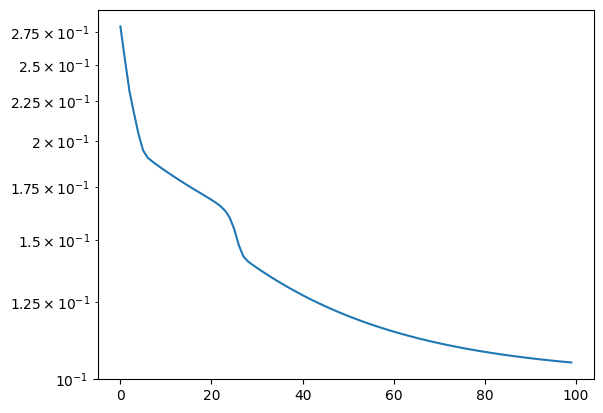

In [41]:
plt.semilogy(running_losses_smaller_batch_larger_regul)

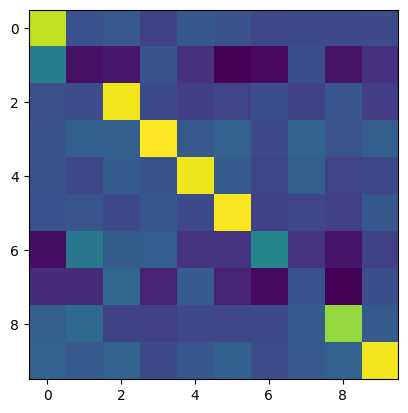

In [42]:
plt.imshow(myMLP1.state_dict()['l1.weight'])

In [43]:
torch.mean((myMLP1.forward(X)-X)**2)

tensor(0.1047, grad_fn=<MeanBackward0>)

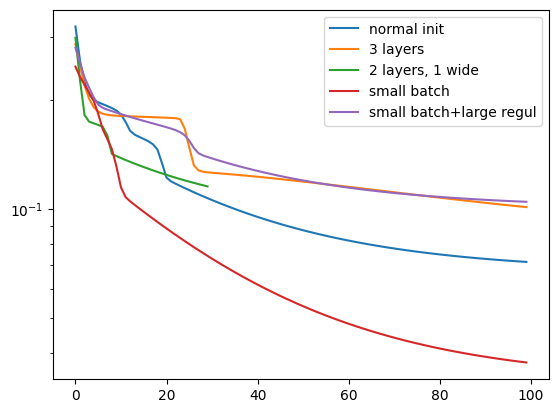

In [47]:

plt.semilogy(running_losses_normal_init, label= "normal init")
# plt.semilogy(running_losses_boosted)
plt.semilogy(running_losses_3layers, label= "3 layers")
plt.semilogy(running_losses_2layers, label= "2 layers, 1 wide")
plt.semilogy(running_losses_smaller_batch, label= "small batch")
plt.semilogy(running_losses_smaller_batch_larger_regul, label= "small batch+large regul")
plt.legend()